# 1.11 Stepik ML contest - data preprocessing

## Введение

Продолжаем предобрабатывать данные

+ В этом уроке познакомимся с [merge и join](http://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) в Pandas
+ А также рассмотрим продвинутый прием по работе с данными при помощи метода [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

В целом число пройденных степов мы могли бы получить проще - из другой таблицы. 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
events_data = pd.read_csv('event_data_train.zip', compression='zip')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data = pd.read_csv('submissions_data_train.zip', compression='zip')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Для нашей задачи очень важная информация как долго пользователь взаимодействовал с контентом, насколько хорошо у него это получалось.

И это нам потребуется для ответа на наш вопрос.

## Предобработка данных

Добавим колонки, нужные нам для дальнейшей работы с данными в dataframe.

### Добавление колонки date

In [ ]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

### Добавление колонки day

In [ ]:
submissions_data['day'] = submissions_data.date.dt.date

### Проверим, что колонки добавились

In [ ]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Давайте рассчитаем для каждого юзера сколько у него было данных, для которых был правильный correct submit

In [ ]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D16A780>]],
      dtype=object)

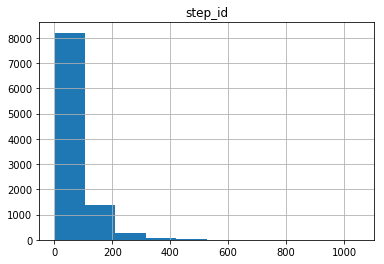

In [ ]:
submissions_data.groupby('user_id').agg({'step_id': 'count'}).hist()

Мы получили для каждого user_id сколько у него было правильных и неправильных сабмитов за всю историю общения эти пользователей со степиком.

Таким образом, самым первым и важным этапом является предварительная работа с данными.

Можно посмотреть, например:

+ количество уникальны колонок action
+ проверить временной интервал в данных
+ построить графики

Давайте построим простые фичи для каждого пользователя. Посчитаем, скажем, сколько у него было уникальных степов, которые он прошёл. Сколько было правильных и неправильных сабмитов и сколько уникальных дней он учился на степике.

А дальше посмотрим различаются ли эти показатели для пользователей, успешно окончивших курс, и пользователей, которые курс бросили.

Здесь возникает важнй нюанс и то, как мы ответим на этот вопрос, будет полностью влиять на то какую задачу мы решаем и как.

Мы сейчас мысленно перенеслись в 2018-й год и у нас очень большой процент пользователей находится в процессе. Он мог зарегистрироваться неделю назад и 2 дня порешал, а потом 5 дней его не было.

Вопрос: этот пользователь бросил курс или нет? Нам нужно подгрузить ещё данных, чтобы проверить это?

С 5 днями понятно, а если речь идёт о 25 днях или больше.

С пользователями, которые прошли курс, т.е. получили сертификат, всё понятно.

Но есть ещё две важных группы пользователей:
+ незакончившие курс вообще
+ юзеры в процессе

Важно отличить эти две группы.

Мы можем ввести эвристики. Например, пользователь, который месяц не был на курсе считается покинувшим его. Но тут важно понимать, что такие эвристики должны быть основаны на данных и наблюдениях, а не взяты из воздуха.

Можно построить распределения перерывов между сабмитами у участников нашего курса. Если пользователь не появляется на нашем курсе больше, чем N дней, то с вероятностью 95% считаем его покинувшим курс.

Варьируя этот показатель можно обучать более жёсткие/более мягкие классификаторы. В дальнейшем нам это может пригодиться.

Подготовим наши данные, чтобы получился размеченный датасет. Те пользователи, которые закончили курс, дропнувшиеся пользователи. И несколько понятных фичей.

Теперь давайте подойдём к ещё одной очень важной теме - мы её уже затрагивали, и сейчас это ключевой момент для решения всей задачи.

Мы хотим предсказывать тех пользователей, кторые дропнулись с курса. Которые не дорешали его до конца, ушли и больше не вернулись.

У нас в данных нет какого-то показателя ушёл пользователь или нет. Более того, это понятие не совсем определено. Например человек не был на курсе уже две недели, хотя он зарегистрировался на курсе совсем недавно. 2 недели - это достаточно, чтобы считать его дропнувшимся?

Или это принятая стратегия прохождения курсов - перерывы в две недели?

На такой вопрос лучше отвечать на основе данных статистического анализа, а не просто взяв из головы некоторую эвристику, например, **будем считать дропнувшимися всех пользователей, отсутствующих на курсе месяц**. Почему месяц, а не два или три? Или наоборот почему не 3 или 2 недели?

Поэтому для ответа на этот вопрос проанализируем данные, которые у нас есть.

Одна из стратегий:
Для каждого пользователя рассчитать какие у него были промежутки в перерывах между уникальными днями, когда он проходил курс. Далее посмотреть на картину по всем пользователям и принять статистическое решение.

Ответить на этот вопрос более статистически нам помогут данные events_data. Мы посмотрим как в среднем распределены перерывы в решении курса у юзеров. И, тем самым, ответим на вопрос - какой временной промежуток отсутствия на курсе можно считать пороговым, после которого мы будем считать пользователя дропнувшимся.

Для этого сделаем следующее:
посмотрим для каждого пользователя какие перерывы в днях у него наблюдаются в момент прохождения курса.

В течение дня может быть несколько событий с одним и тем же timestamp, но нам эта информация не нужна. Если человек хотя бы раз зашел в этот день будем считать его активным в этот день.

In [ ]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates().head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895
6,17632,2015-06-15,1434340921
8,17632,2015-06-15,1434340939
9,17632,2015-06-15,1434340944


## Как работает drop_duplicates()?

Сначала давайте рассмотрим небольшой датафрейм с двумя колонками.

In [ ]:
events_data[['step_id', 'user_id']].head()

,step_id,user_id
0,32815,17632
1,32815,17632
2,32815,17632
3,32811,17632
4,32811,17632


А теперь давайте применим к нему рассматриваемый метод

In [ ]:
events_data[['step_id', 'user_id']].head().drop_duplicates()

,step_id,user_id
0,32815,17632
3,32811,17632


Как видно из результатов запроса выше, метод drop_duplicates() оставил только первые вхождения в датафрейм каждой из дублирующихся пар 'step_id', 'user_id' 

Единственная тонкость нашего примера в том, что мы хотим взять уникальные значения по user_id и day, а timestamp взять первый или последний.

В таком случае задаётся аргумент subset, принимающий колонки по которым будет дедубликация

In [ ]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(['user_id', 'day']).head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


Как мы видим, такая команда оставила для каждого юзера только одну строчку для каждого дня, когда он был онлайн.

Мы для каждого пользовател отобрали его timestamp, и этот timestamp - значение того дня, когда он был онлайн.

Теперь соберём для каждого пользователя все его timestamp'ы, в которые он был на курсе и посмотрим перерывы между ними.

In [ ]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

**Что сделал метод apply?**

Он поместил все значения, которые мы получили в прошлом запросе, в списки.

**Что можно сказать на основе полученных данных?**

Пользователь 1 был один раз на курсе. Пользователь 2 - 2 раза, а пользователь 3 - не менее 4 раз.

А для нас представляют интерес перерывы между этими днями.

In [ ]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff)

**Что делает второй вызов метода apply в примере выше?**

np.diff считает разность между ближайшими наблюдениями

### Примеры работы np.diff

In [ ]:
np.diff([1, 2, 5])

NameError: ignored

Поскольку 2 - 1 = 1 и 5 - 2 = 3 мы и получаем соответствующий массив: [1, 3]

In [ ]:
np.diff([1, 3, 7, 14])

NameError: ignored

А нам интересно сколько времени прошломежду блиайшимиднями когда пользователь был на курсе.

Вернёмся к нашему запросу.

In [ ]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).head()

Если вызвать атрибут values для выражения выше, то мы получим массив массивов - для каждого юзера сохранена разница между двумя ближайшими заходами, которые у него были на курсе.

In [ ]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [ ]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

Теперь нужно массив массивов перевести в один массив.



In [ ]:
np.concatenate(gap_data, axis=0)

In [ ]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [ ]:
gap_data

Теперь у нас в Seies сохранены для каждого пользователя и для всех пользователей в том числе значения разницы между двумя ближайшими заходами на курс.

Для получения разницы в днях нужно все значения из gap_data поделить на: 24 * 60 * 60

In [ ]:
gap_data / (24 * 60 * 60)

In [ ]:
gap_data = gap_data / (24 * 60 * 60)

Давайте изучим, что же у нас получилось. Можно построить гистограмму.

In [ ]:
gap_data.hist()

На данном графике присутствуют выбросы, встречающиеся при работе с живыми данными, давайте избавимся от них.

In [ ]:
gap_data[gap_data < 208].hist()

Обратите внимание, что большая часть всех gap'ов между двумя заходами укладывается в диапазон между 0 и 25 днями.

Давайте посчитаем более точно эту цифру. Возьмём просто квантиль, скажем 95-й

In [ ]:
gap_data.quantile(0.95)

Что мы узнали, получив эту цифру?

Только 5% пользователей возвращаются на курс после перерыва в 2 месяца.

In [ ]:
gap_data.quantile(0.90)

А 90% укладываются в интервал до 18 дней.

Мы можем взять значение 30 дней в качестве оценки между 90-м и 95-м процентилем.

Используем это значение, чтобы определить, какое же время отсутствия на курсе можно использовать, чтобы считать пользователя дропнувшимся?

Давайте для начала разметим наших пользователей по принципу того являются ли они уже дропнувшимися с нашего курса или нет. 

Кстати, нужно понимать, что если пользователь 2 месяца не появляется на курсе, но при этом и курс уже прошёл, т.е. он набрал уже большую часть баллов и получил сертификат, то он тоже не является дропнушимся по понятным причинам.

То есть у нас будет составное условие.

Если человек не получил сертификат и при этому более 30 дней отсутствует на платформе - считаем, что он дропнулся с курса. 

Как мы это сделаем?

Определим финальный день:

In [ ]:
events_data.tail()

2018-05-19 - финальный день курса. Давайте отсчитывать отвалившихся пользователей от этого дня.

Как мы это сделаем?

Давайте для каждого пользователя рассчитаем его максимальный timestamp.

In [ ]:
events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).head()

Нас теперь интересует - правда ли, что этот максимальный timestamp больше, чем заведенное нами значение.

In [ ]:
30 * 24 * 60 * 60 # пороговое значение

Теперь для каждого пользователя нужно понять, сколько времени прошло с момента его последнего посещения на текущий день. 

Под текущим днём мы понимаем 19.05.2018

Для этого сделаем так

In [ ]:
user_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})
user_data.head()

Возьмём теперь финальный timestamp из наших данных `events_data.tail()` - 1526772811 и используем его в запросе ниже.

In [ ]:
user_data['is_gone_user'] = 1526772811 - user_data.last_timestamp

In [ ]:
user_data.head()

Последний столбец содержит информацию сколько времени прошло с момента последнего посещения ользователя по сравнению с 19.05.2018.

Давайте обернём это в 1 или 0 в зависимости от того больше это нашего порогового значения или меньше.

Введём переменные:

In [ ]:
now = 1526772811
drop_out_treshold = 2592000 # пороговое значение, которое посчитано чуть выше

In [ ]:
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_out_treshold

In [ ]:
user_data.head()

Теперь нужно уточнить, что эти пользователи не прошли курс и тогда задача будет решена.

Итак, это пока даже не dataframe, который мы будем использовать для обучения моделей, мы отдельно обсудим чего ещё не хватает, даже с точки зрения именно сбора данных, пока это некая такая ввдная агрегированная таблица по юзерам.

Мы хотим посмотреть, когда юзер последний раз был онлайн, является ли он дропнувшимся юзером, сколько у него баллов и какое число попыток. Это даже ещё не данные для модели, скорее просто данные для дальнейшего исследования.

Давайте теперь примержим к этой табличке анные про число попыток(успешных и неуспешных) и число набранных баллов и посмотрим, что получается.

Давайте добавим данные про количество правильных и неправильыых решений.

Воспользуемся методом `merge` для соединения таблиц по user_id.

In [ ]:
user_data.merge(users_scores).head()

Табличка содержит помимо информации о пользователе, которая была в user_data ещё и информацию о попытках из users_score. 

Есть проблема - мы потеряли данные.

Что мы потеряли?

В users_score хранятся данные о попытках пользователя - correct и wrong. А что если пользователь вообще не отправлял данные?

Например, у пользователя 1 вообще нет попыток - ни правильных ни неправильных. И в результате мерджа он пропал из результирующей таблицы выше.

Поэтому, когда мы делаем мердж или джойн нужно помнить, что когда мы мерджим по умолчанию скорее всего будет использован inner merge. То есть будут взяты только те пользователи, которые есть в каждом из датафреймов, то есть пересечение.

Это решается добавление аргумента how='outer'.

In [ ]:
user_data.merge(users_scores, how='outer').head()

Пользователь с user_id = 1 теперь попал в итоговую выдачу, что мы и ожидали.

Теперь при таком мердже получилось так, что записи, отсутствующие в одной из таблиц, всё равно будут в результирующей, но они будут заполнены NaN.

Это важно понимать и всегда нужно проверять себя на непротиворечивость в данных, чтобы мы никого нигде не потеряли.

**Когда мы делаем мердж и не указываем ключ, по которому нужно делать мердж -> pandas автоматически ищет колонку с одинаковым названием. Можно указать ключ явно в качестве значения аргумента on.**

In [ ]:
user_data.merge(users_scores, on='user_id', how='outer').head()

Если применить метод head() к таблице, указанной внутри метода merge(), то мы получим только 5 строк в результирующей таблице.

In [ ]:
user_data.merge(users_scores.head())

Соответственно, сделав операцию присваивания данного датасета переменной user_data мы перетерли бы исходные данные, поскольку по умолчанию merge - inner.

**Для того, чтобы не запутывать вас в манипуляциях с данными я присвоил результат даного запроса новой переменной user_data2, а не user_data2 (как было в лекции)**

In [ ]:
user_data2 = user_data.merge(users_scores.head())
user_data2

Датасет вернул всего 5 строк, о чём и была речь.

Поэтому будьте внимательны!

А второй важный момент: не забывайте убирать head() при переприсвоении датасетов.

In [ ]:
user_data3 = user_data.merge(users_scores, on='user_id', how='outer').head()

In [ ]:
user_data3

Тоже ничего хорошего.

Давайте теперь всё же выполним наш мёрдж датасетов.

In [ ]:
user_data = user_data.merge(users_scores, on='user_id', how='outer')

Теперь давайте избавимся от NaN в нашем результирующем датасете -> заменим их 0.

In [ ]:
user_data = user_data.fillna(0)

In [ ]:
user_data.head(20)

Пользователь с user_id = 1 дропнулся и у него не было никаких попыток решения задач. Пользователь 7 продолжает учиться, но у него тоже пока нет попыток решения задач.

Давайте теперь прикрутим данные и про остальные события.

In [ ]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [ ]:
users_events_data.head()

Для каждого юзера у нас есть подсчёт его событий. И давайте теперь приджойним этот датасет к нашему ранее созданному смердженному датасету.

In [ ]:
user_data = user_data.merge(users_events_data, how='outer')

In [ ]:
user_data.head()

Пожалуй, сейчас в данной таблице есть вся интересующая информация о пользователе, кроме одной важной фичи - сколько уникальных дней пользователь был в сервисе.

Добавим эту статистику.

In [ ]:
users_days = events_data.groupby('user_id').day.nunique()
users_days.head()

### Как перейти от пандасовской серии к датафрейму?

```python
series_name.to_frame().reset_index()
```

# New Section

In [ ]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


Давайте теперь домёрджим это к нашей табличке, в которой мы собираем информацию о наших пользователях.

In [ ]:
user_data = user_data.merge(users_days, how='outer')

In [ ]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Проверяем, что мы никого не потеряли, смотрим на количество юзеров.

In [ ]:
user_data.user_id.nunique()

19234

In [ ]:
events_data.user_id.nunique()

19234

**Хорошая практика - проверка себя на каждом этапе, что мы нигде не потеряли данные**

Последняя колонка которую мы хоти добавить - показатель того, что пользователь успешно закончил курс.

Например, пользователь набрал более 175 пройденных шагов.

Тогда сделаем ещё одну колонку.

In [ ]:
user_data['passed_course'] = user_data.passed > 175

In [ ]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [ ]:
user_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17844,17844,17844,17844,17844,17844,17844,17844,17844,17844
True,1390,1390,1390,1390,1390,1390,1390,1390,1390,1390


## Типы merge и join

### merge
![](https://ucarecdn.com/f03da508-b426-42c6-be37-ccd7627ca8a4/)
### join
![](https://ucarecdn.com/4614d509-542e-44ca-ad74-ca27b78ad787/)